In [1]:
import string
import re
from collections import Counter

import pandas as pd
import numpy as np
import nltk
import langid

from numpy.linalg import norm
import seaborn as sns
import re 

import matplotlib.pyplot as plt 

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paola.YELA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Paola.YELA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paola.YELA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Quality Assessment of DFS Tagging of _2019 HNO Nigeria_ report

The present notebook assess the quality of the tagging process of the DFS team to the 2019 HNO Nigeria report. The quality of this tagging process, is taken as a proxy of the quality of the tagging process carried on by the DFS team in the IFRC documents, which includes VCA, DREF, Emergency Appeals, Lessons Learnt and other Evaluations, carried on between February and June of 2019.

For this Vector Space Model (VSM)-Based Indexing Similarity Measures were taken. Based mainly in the work of [Choi (2015)](https://onlinelibrary.wiley.com/doi/abs/10.1002/asi.23198).

## 1) Data preprocessing

Generating the dataset with all the sentences that were evaluated by at least one of the analysts. With this approach, the information ignored from the report, is the one that was considered not relevant by all of the analysts.

### 1.1) Removal of excerpts of images 

The anlysts tagged pieces of text and images. When each analyst tagged an image, a different link was generated, difficulting therefore the content comparison. The consistancy metric for this type of information is therefore ignored.  

In [2]:
#reading data
data_folder = 'data/IFRC/data_DEEP/'
excerpts_file = '20190530_DEEP_Entries_Export_ng0Wmpc.xlsx'
#excerpts_DEEP = pd.read_excel(data_folder + excerpts_file, usecols = [6], encoding="ascii")
excerpts_DEEP = pd.read_excel(data_folder + excerpts_file, encoding="ascii")
excerpts_DEEP.sample(3)

,Date of Lead Publication,Imported By,Date Imported,Lead Title,Source,Assignee,Excerpt,RELIABILITY,Flag - Dimension,Flag - Subdimension,...,Sectoral Information - Dimension,Sectoral Information - Subdimension,Sectoral Information - Sector,Sectoral Information - Subsectors,Country,Country (code),State,State (code),Local Authority,Local Authority (code)
254,2019-01-01,Shweta Khatri,2019-05-27,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,"During 2019, 7.1 million Nigerians will requir...",NaN,Flag,Overview,...,Humanitarian Conditions,"Humanitarian conditions, People with Specific ...",Cross,NaN,Nigeria,Nigeria,"Borno, Adamawa, Yobe","Borno, Adamawa, Yobe",NaN,NaN
325,2019-01-01,Shweta Khatri,2019-05-27,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,"However, community perceptions and misundersta...",NaN,NaN,NaN,...,Humanitarian Conditions,"Physical & mental wellbeing, Risks & Vulnerabi...",Protection,NaN,Nigeria,Nigeria,NaN,NaN,NaN,NaN
834,2019-01-01,Nagma Mathema,2019-05-27,2019 HNO Nigeria Consistency_Nagma.pdf,OCHA,Kriti Chhetri,https://api.thedeep.io/public-file/MTM0Nzc/kib...,NaN,NaN,NaN,...,Humanitarian Conditions,"Humanitarian conditions, People with Specific ...",Nutrition,NaN,Nigeria,Nigeria,"Borno, Yobe, Adamawa","Borno, Yobe, Adamawa",NaN,NaN


In [3]:
image_links = excerpts_DEEP[excerpts_DEEP['Excerpt'].str.contains('https://api.thedeep.io/public-file/')]
print ("Percentage of images in tagged data: ", np.round(len(image_links)/len(excerpts_DEEP)*100), "%")

Percentage of images in tagged data:  13.0 %


In [4]:
excerpts_DEEP = excerpts_DEEP[~excerpts_DEEP['Excerpt'].str.contains('https://api.thedeep.io/public-file/')]
excerpts_DEEP.head(3)

,Date of Lead Publication,Imported By,Date Imported,Lead Title,Source,Assignee,Excerpt,RELIABILITY,Flag - Dimension,Flag - Subdimension,...,Sectoral Information - Dimension,Sectoral Information - Subdimension,Sectoral Information - Sector,Sectoral Information - Subsectors,Country,Country (code),State,State (code),Local Authority,Local Authority (code)
0,2019-01-01,Kriti Chhetri,2019-05-23,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,"Across the three affected states of Borno, Ada...",NaN,NaN,NaN,...,Humanitarian Conditions,"Living Standards, Humanitarian conditions, Cop...","Shelter, Cross",NaN,Nigeria,Nigeria,"Borno, Adamawa, Yobe","Borno, Adamawa, Yobe",NaN,NaN
1,2019-01-01,Kriti Chhetri,2019-05-23,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,One in four of the internally displaced people...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Nigeria,Nigeria,Borno,Borno,NaN,NaN
2,2019-01-01,Kriti Chhetri,2019-05-23,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,North-east Nigeria is one of the world’s large...,NaN,Flag,Overview,...,Humanitarian Conditions,"Living Standards, Physical & mental wellbeing,...",Protection,NaN,Nigeria,Nigeria,"Adamawa, Yobe, Borno","Adamawa, Yobe, Borno",NaN,NaN


In [5]:
#columns useful, in order to merge with other datasets
excerpts_DEEP['id_excerpt'] = excerpts_DEEP.axes[0]

### 1.2) From excerpts to sentences

The unit of analysis are set to be sentences. As an excerpt may contain more than one sentence, the dataset is re organized accordingly. 
For this, first, the points inside numbers are changed by commas. And then, the rest of the points, is assumed to be dividing sentences. 

This step is important as an excerpt (e.g. union of two sentences) may have been tagged by an analyst as a relevant "unit", while another analyst may have tagged both sentences by separate as relevant. The conclusion by both analysts is that both sentences are relevant. And we should be able of capture this.

Part of the code was taken from the Github account of Navid Rekabsaz.

In [6]:
def ch_points_nums(inp, col=None):
    """Change punctuation inside numbers for either a df (and col)
    or single entry. If point is working as separator of sentence, is not changed.
    """
    
    def dig_ch(wrd):
        "Change the point if it's in the middle of a word."
        s = list(wrd)
        for j in range(0, len(s)):
            if (s[j] == '.' and j != 0 and j != len(s) -1):
                s[j] = ','
        return "".join(s)
  
    def sing_ch(phr):
        """Change for a single entity"""
        return ' '.join([dig_ch(i) if (
                    any(j == '.' for j in i) and 
                    any(j.isdigit() for j in i) and 
                    not any(j.isalpha() for j in i)
                    ) else ''.join(i)
                for i in str(phr).split(' ')]
        )
    if col and isinstance(inp, pd.core.frame.DataFrame):
        return inp.filter(like=col).applymap(lambda phr: sing_ch(phr))
    elif isinstance(inp, str):
        return sing_ch(inp)
    else:
        raise Exception('Not a vaild type')

from functools import reduce
def compose(*functions):
    def compose2(f1, f2):
        """Compose two functions"""
        return lambda *args: f1(f2(*args))
    return reduce(compose2, functions)

def simple_preprocess(row):
        inp = row['Excerpt']
        func = compose( 
            ch_points_nums,
            ' '.join,
            str.split,
            str
        )
        return func(inp)
    
print ('Testing...')
print (simple_preprocess({'Excerpt': 'The 2.2 quick brown foxes jumped over the lazy dogs. Sometimes 6.6. .2 In the winter asd.13.24. cases.66 Nearly'}))

Testing...
The 2,2 quick brown foxes jumped over the lazy dogs. Sometimes 6,6. .2 In the winter asd.13.24. cases.66 Nearly


In [7]:
excerpts_DEEP['excerpt_preprc'] = excerpts_DEEP.apply(simple_preprocess, axis=1)
excerpts_DEEP.sample(3)

,Date of Lead Publication,Imported By,Date Imported,Lead Title,Source,Assignee,Excerpt,RELIABILITY,Flag - Dimension,Flag - Subdimension,...,Sectoral Information - Sector,Sectoral Information - Subsectors,Country,Country (code),State,State (code),Local Authority,Local Authority (code),id_excerpt,excerpt_preprc
231,2019-01-01,Shweta Khatri,2019-05-24,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,The situation in these areas is reportedly mor...,NaN,NaN,NaN,...,Protection,NaN,Nigeria,Nigeria,Borno,Borno,NaN,NaN,231,The situation in these areas is reportedly mor...
355,2019-01-01,Shweta Khatri,2019-05-27,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,Road transport obstacles when delivering mater...,NaN,NaN,NaN,...,NaN,NaN,Nigeria,Nigeria,"Borno, Adamawa, Yobe","Borno, Adamawa, Yobe",NaN,NaN,355,Road transport obstacles when delivering mater...
377,2019-01-01,Shweta Khatri,2019-05-27,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,The 2018 agricultural season has been progress...,NaN,NaN,NaN,...,"Cross, Agriculture, Food, Protection",NaN,Nigeria,Nigeria,"Borno, Adamawa, Yobe","Borno, Adamawa, Yobe",NaN,NaN,377,The 2018 agricultural season has been progress...


In [8]:
sentences = excerpts_DEEP['excerpt_preprc'].str.split('.',expand=True)
sentences['id_excerpt'] = sentences.axes[0]
sentences.head(8)

,0,1,2,3,4,5,6,7,id_excerpt
0,"Across the three affected states of Borno, Ada...",Over eighty per cent of internally displaced ...,,None,None,None,None,None,0
1,One in four of the internally displaced people...,"However, some 1,6 million people have returne...",Humanitarian organisations are not able to me...,,None,None,None,None,1
2,North-east Nigeria is one of the world’s large...,"Since the start of the conflict in 2009, more...",Attacks on camps for internally displaced peo...,,None,None,None,None,2
3,Millions of people in north-east Nigeria rely ...,Despite significant improvements in 2017 and ...,More than 5 million people need health assist...,Basic survival needs are compounded by access...,,None,None,None,3
4,Humanitarian access is often impeded or restri...,The humanitarian community also faces restric...,Many areas of Borno State are considered high...,"More than 800,000 people are estimated to be ...",,None,None,None,4
5,"In 2019, 7,1 million people (2,3 million girls...","The crisis, which is fundamentally a protecti...",,None,None,None,None,None,5
9,"Today 1,8 million people are internally displa...","The crisis has impacted women, men, girls and...","Women and girls have been targeted with rape,...",,None,None,None,None,9
10,Men and boys have been mainly targeted for rec...,While the humanitarian community provided lif...,,None,None,None,None,None,10


In [9]:
sentences = sentences.melt(id_vars=['id_excerpt'],value_name='value')
sentences = sentences.drop(columns = ['variable'])
sentences.sample(5)

,id_excerpt,value
5448,128,None
2005,552,"About 3,000 children were released from admin..."
2977,796,None
2486,224,
4157,373,


In [10]:
sentences = sentences[sentences['value'] != '']
sentences = sentences[sentences['value'].notnull()]
sentences.sample(5)

,id_excerpt,value
407,463,The majority of crisis-affected people have ex...
1039,303,"Additionally, girls and boys affected are inc..."
1365,693,Despite a scale up of nutrition interventions...
875,126,"Survivors need continuous safe, confidential,..."
1514,866,In addition to primary displacements to camps...


In [11]:
sentences_DEEP = excerpts_DEEP.merge(sentences)

In [12]:
sentences_DEEP = sentences_DEEP.rename(columns={'value':'Sentence'})
sentences_DEEP.head(3)

,Date of Lead Publication,Imported By,Date Imported,Lead Title,Source,Assignee,Excerpt,RELIABILITY,Flag - Dimension,Flag - Subdimension,...,Sectoral Information - Subsectors,Country,Country (code),State,State (code),Local Authority,Local Authority (code),id_excerpt,excerpt_preprc,Sentence
0,2019-01-01,Kriti Chhetri,2019-05-23,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,"Across the three affected states of Borno, Ada...",NaN,NaN,NaN,...,NaN,Nigeria,Nigeria,"Borno, Adamawa, Yobe","Borno, Adamawa, Yobe",NaN,NaN,0,"Across the three affected states of Borno, Ada...","Across the three affected states of Borno, Ada..."
1,2019-01-01,Kriti Chhetri,2019-05-23,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,"Across the three affected states of Borno, Ada...",NaN,NaN,NaN,...,NaN,Nigeria,Nigeria,"Borno, Adamawa, Yobe","Borno, Adamawa, Yobe",NaN,NaN,0,"Across the three affected states of Borno, Ada...",Over eighty per cent of internally displaced ...
2,2019-01-01,Kriti Chhetri,2019-05-23,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,One in four of the internally displaced people...,NaN,NaN,NaN,...,NaN,Nigeria,Nigeria,Borno,Borno,NaN,NaN,1,One in four of the internally displaced people...,One in four of the internally displaced people...


Note: In some cases ";" is also used for separate sentences. However, it is not the rule, and therefore such separator is not taken into account.

### 1.3) Creating baseline dataset

The baseline dataset contains "unique" sentences. The qualitative analysis of the dataset, showed a lot of minor differences in the sentences (not spaces, numbers merged, addition of reference numbers), that make that two sentences that contain the same idea, doesn't have an exact match. For this a similarity measure is taken.

In [13]:
from difflib import SequenceMatcher

#Where T is the total number of elements in both sequences, and M is the number of matches, this is 2.0*M / T. Note that this is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.
def similar(a, b):
    return SequenceMatcher(None, a, b).quick_ratio()

a = " 21 per cent and 85 per cent of respondents in Yobe and Borno states, respectively, indicate that women and girls face protection risks including sexual harassment when collecting firewood"
b = "21 per cent and 85 per cent of respondents in Yobe and Borno states"

similar(a,b)

0.5254901960784314

In [14]:
#what is similar enough?
sim_criteria = 0.95

In [15]:
# Need for optimization (Now taking around 3 minutes). Maybe first defining function for replace similar strings, and then search observation in dataset by intersection (sets perspective)
baseline_dataset = []
baseline_dataset.append(str(sentences_DEEP['Sentence'][0]))
for i in range (1, len(sentences_DEEP)):
    count = 0
    for j in range (0, len(baseline_dataset)):
        if (similar(str(sentences_DEEP['Sentence'][i]),baseline_dataset[j]) >= sim_criteria):
            sentences_DEEP['Sentence'][i] = baseline_dataset[j]
            break
        else:
            count = count + 1
    if(count == len(baseline_dataset)):
        baseline_dataset.append(str(sentences_DEEP['Sentence'][i]))

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
len(baseline_dataset)

555

In [17]:
baseline = pd.DataFrame(baseline_dataset, columns=['Sentence'])
baseline.head(5)

,Sentence
0,"Across the three affected states of Borno, Ada..."
1,Over eighty per cent of internally displaced ...
2,One in four of the internally displaced people...
3,"However, some 1,6 million people have returne..."
4,Humanitarian organisations are not able to me...


In [18]:
file_descriptors = 'sentences.xlsx'
sentences_DEEP.to_excel(file_descriptors, header=True)

## 2) Construction of indexing space

The quality assessment is done at four levels, and for each one of those levels of analysis an indexing space is created.

1. __Relevance of sentence:__ whether analysts considered the same sentence as relevant (tagged it or not) 
2. __Macro-dimension of sentence:__ whether analysts agreed on the relevance of the related macrocategories (any of the values in a dimension->macro dimension is relevant)
3. __Dimension of sentence:__ whether analysts agreed on the categories (dimensions/sectors) related to a sentence (tagged sentences in the same macro category or not) 
4. __Subdimension of sentence:__ whether analysts agreed on the subcategories related to a sentence (tagged sentences in the same categories or not)
5. __Full vocabulary:__ whether analysts agreed on all the categories/subcategories/others related to a sentece

In [19]:
#Need for definition in the general case, where are the names of the analysts? In 'Imported By' or 'Assignee'. 
#In this case it is in 'Imported By'
analysts = sentences_DEEP['Imported By'].unique()
analysts

array(['Kriti Chhetri', 'Shweta Khatri', 'Sapana Dangol', 'Nagma Mathema'],
      dtype=object)

### 2.1) Indexing space - Relevance of sentence

In [20]:
#whether each one of the analysts considered relevant a sentence or not
relevance = baseline.copy()
for i in analysts:
    relevance[i] = relevance['Sentence'].isin(sentences_DEEP['Sentence'][sentences_DEEP['Imported By'] == i]).astype(int)
relevance.sample(5)

,Sentence,Kriti Chhetri,Shweta Khatri,Sapana Dangol,Nagma Mathema
32,There are regular reports of extra-judicial ki...,1,1,1,1
512,"In 2018, cholera outbreaks affected 18 LGAs i...",0,1,1,1
80,"In Borno State, many affected populations rema...",1,1,1,1
440,"In addition, the destruction and/or looting o...",1,1,1,1
191,Unavailability of network coverage in newly ac...,1,0,1,1


In [21]:
#centroid (average vector across all indexers/taggers)
a = []
for i in analysts: 
    a.append(relevance[i])

relevance['Centroid'] = np.mean(a, axis=0)
relevance.sample(5)

,Sentence,Kriti Chhetri,Shweta Khatri,Sapana Dangol,Nagma Mathema,Centroid
116,"Insecurity, particularly in Borno State, cont...",1,0,1,0,0.5
357,The unavaibility of viable land to meet the im...,1,1,1,1,1.0
368,The three main NFIs requested by the affected...,1,1,1,1,1.0
454,These socio-economic activities also increase...,1,1,1,1,1.0
184,The delivery of quality services and referral...,1,1,1,1,1.0


In [22]:
#In order to compare the categories tagged, just the sentences that were "relevant" for all of the analysts are used.
relevant = pd.DataFrame(relevance['Sentence'][relevance['Centroid'] == 1.0])
relevant.sample(5)

,Sentence
134,The severe damage to key public infrastructure...
311,Ongoing and protracted displacement puts an ad...
5,North-east Nigeria is one of the world’s large...
410,"In Borno State, the ongoing crisis and milita..."
349,"Of the total 1,6 million returnees, 421,000 ha..."


In [23]:
print('Number of sentences in common between all analysts: ',len(relevant))

Number of sentences in common between all analysts:  417


### 2.2) Indexing space - Macro-dimension of sentence

In [24]:
macro_dimension = relevant.copy()

In [25]:
#define macrocategories (let just features that indicate a dimension or a sector)
all_features = pd.DataFrame(list(sentences_DEEP), columns = ['Features'])
d = re.compile(r'.*- Dimension.*')
s = re.compile(r'.*- Sector.*')
macro_features = all_features[all_features['Features'].apply(lambda x: bool(d.match(x) or s.match(x)))]
macro_features

,Features
8,Flag - Dimension
15,Operational Environment - Dimension
18,Sectoral Information - Dimension
20,Sectoral Information - Sector


In [26]:
#define space for tags. A tag is done for each analyst and for each macro dimension.
for i in macro_features['Features']:
    for j in analysts:
        #dataset analyst
        temp_ana = sentences_DEEP[sentences_DEEP['Imported By'] == j]
        #dataset macro dimension (any of the dimensions was taken into account)
        temp_dim_ana = temp_ana[~temp_ana[i].isnull()]
        #dimension and analyst
        macro_dimension[str(i)+" "+str(j)] = (macro_dimension['Sentence'].isin(temp_dim_ana['Sentence'])).astype(int)
macro_dimension.head(3)

,Sentence,Flag - Dimension Kriti Chhetri,Flag - Dimension Shweta Khatri,Flag - Dimension Sapana Dangol,Flag - Dimension Nagma Mathema,Operational Environment - Dimension Kriti Chhetri,Operational Environment - Dimension Shweta Khatri,Operational Environment - Dimension Sapana Dangol,Operational Environment - Dimension Nagma Mathema,Sectoral Information - Dimension Kriti Chhetri,Sectoral Information - Dimension Shweta Khatri,Sectoral Information - Dimension Sapana Dangol,Sectoral Information - Dimension Nagma Mathema,Sectoral Information - Sector Kriti Chhetri,Sectoral Information - Sector Shweta Khatri,Sectoral Information - Sector Sapana Dangol,Sectoral Information - Sector Nagma Mathema
0,"Across the three affected states of Borno, Ada...",0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
1,Over eighty per cent of internally displaced ...,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
2,One in four of the internally displaced people...,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0


In [27]:
#centroid - calculated for each category (average vector across all indexers/taggers)
for i in macro_features['Features']:
    a = []
    for j in analysts:
        a.append(macro_dimension[str(i)+" "+str(j)])
    macro_dimension['Centroid'+' '+i] = np.mean(a, axis=0)
macro_dimension.head(3)

,Sentence,Flag - Dimension Kriti Chhetri,Flag - Dimension Shweta Khatri,Flag - Dimension Sapana Dangol,Flag - Dimension Nagma Mathema,Operational Environment - Dimension Kriti Chhetri,Operational Environment - Dimension Shweta Khatri,Operational Environment - Dimension Sapana Dangol,Operational Environment - Dimension Nagma Mathema,Sectoral Information - Dimension Kriti Chhetri,...,Sectoral Information - Dimension Sapana Dangol,Sectoral Information - Dimension Nagma Mathema,Sectoral Information - Sector Kriti Chhetri,Sectoral Information - Sector Shweta Khatri,Sectoral Information - Sector Sapana Dangol,Sectoral Information - Sector Nagma Mathema,Centroid Flag - Dimension,Centroid Operational Environment - Dimension,Centroid Sectoral Information - Dimension,Centroid Sectoral Information - Sector
0,"Across the three affected states of Borno, Ada...",0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,0.0,1.0,1.0,1.0
1,Over eighty per cent of internally displaced ...,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,0.0,1.0,1.0,1.0
2,One in four of the internally displaced people...,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0.0,1.0,0.0,0.0


### 2.3) Indexing space - Dimension of sentence

In [28]:
dimension = relevant.copy()

In [29]:
#creation of additional features
for i in macro_features['Features']:
    if (not all(sentences_DEEP[i].isnull())):
        temp_cat = sentences_DEEP[i].str.split(', ', expand=True).stack().unique()
        if(len(temp_cat) > 1):
            for j in temp_cat:
                #creation of dummy variables indicating whether the category was tagged or not
                ##but handling first nan values (as 0)
                sentences_DEEP [i+' '+j] = (sentences_DEEP[i].str.contains(j).fillna(0)).astype(int)
sentences_DEEP.sample(3)

,Date of Lead Publication,Imported By,Date Imported,Lead Title,Source,Assignee,Excerpt,RELIABILITY,Flag - Dimension,Flag - Subdimension,...,Sectoral Information - Sector Cross,Sectoral Information - Sector Protection,Sectoral Information - Sector Health,Sectoral Information - Sector Nutrition,Sectoral Information - Sector Food,Sectoral Information - Sector Livelihoods,Sectoral Information - Sector Education,Sectoral Information - Sector Agriculture,Sectoral Information - Sector Logistics,Sectoral Information - Sector WASH
489,2019-01-01,Kriti Chhetri,2019-05-27,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,"The sector prioritises 1.3 million people, inc...",NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1628,2019-01-01,Nagma Mathema,2019-05-23,2019 HNO Nigeria Consistency_Nagma.pdf,OCHA,Kriti Chhetri,Two thirds of health facilities have been dama...,NaN,NaN,NaN,...,1,0,1,0,0,0,0,0,0,0
728,2019-01-01,Shweta Khatri,2019-05-27,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,FHH have been compelled to send their children...,NaN,NaN,NaN,...,1,1,1,0,0,1,1,0,0,0


In [30]:
#let just features that indicate specific type of dimension or of sector
all_features = pd.DataFrame(list(sentences_DEEP), columns = ['Features'])
#macro categories didn't have space after "- Dimension"
d = re.compile(r'.*- Dimension .*')
s = re.compile(r'.*- Sector .*')
dim_features = all_features[all_features['Features'].apply(lambda x: bool(d.match(x) or s.match(x)))]
dim_features

,Features
31,Operational Environment - Dimension Humanitari...
32,Operational Environment - Dimension Humanitari...
33,Operational Environment - Dimension Context
34,Operational Environment - Dimension Information
35,Sectoral Information - Dimension Humanitarian ...
36,Sectoral Information - Dimension Scope & Scale
37,Sectoral Information - Dimension Capacities & ...
38,Sectoral Information - Sector Shelter
39,Sectoral Information - Sector Cross
40,Sectoral Information - Sector Protection


In [31]:
#define space for tags. A tag is done for each analyst and for each dimension.
for i in dim_features['Features']:
    for j in analysts:
        #dataset analyst
        temp_ana = sentences_DEEP[sentences_DEEP['Imported By'] == j]
        #dataset dimension (just sentences that were tagged with the dimension)
        temp_dim_ana = temp_ana[temp_ana[i].astype(bool)]
        #dimension and analyst
        dimension[str(i)+" "+str(j)] = (dimension['Sentence'].isin(temp_dim_ana['Sentence'])).astype(int)
dimension.head(3)

,Sentence,Operational Environment - Dimension Humanitarian Access Kriti Chhetri,Operational Environment - Dimension Humanitarian Access Shweta Khatri,Operational Environment - Dimension Humanitarian Access Sapana Dangol,Operational Environment - Dimension Humanitarian Access Nagma Mathema,Operational Environment - Dimension Humanitarian Profile Kriti Chhetri,Operational Environment - Dimension Humanitarian Profile Shweta Khatri,Operational Environment - Dimension Humanitarian Profile Sapana Dangol,Operational Environment - Dimension Humanitarian Profile Nagma Mathema,Operational Environment - Dimension Context Kriti Chhetri,...,Sectoral Information - Sector Agriculture Sapana Dangol,Sectoral Information - Sector Agriculture Nagma Mathema,Sectoral Information - Sector Logistics Kriti Chhetri,Sectoral Information - Sector Logistics Shweta Khatri,Sectoral Information - Sector Logistics Sapana Dangol,Sectoral Information - Sector Logistics Nagma Mathema,Sectoral Information - Sector WASH Kriti Chhetri,Sectoral Information - Sector WASH Shweta Khatri,Sectoral Information - Sector WASH Sapana Dangol,Sectoral Information - Sector WASH Nagma Mathema
0,"Across the three affected states of Borno, Ada...",1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Over eighty per cent of internally displaced ...,1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,One in four of the internally displaced people...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#centroid - calculated for each category (average vector across all indexers/taggers)
for i in dim_features['Features']:
    a = []
    for j in analysts:
        a.append(dimension[str(i)+" "+str(j)])
    dimension['Centroid'+' '+i] = np.mean(a, axis=0)
dimension.head(3)

,Sentence,Operational Environment - Dimension Humanitarian Access Kriti Chhetri,Operational Environment - Dimension Humanitarian Access Shweta Khatri,Operational Environment - Dimension Humanitarian Access Sapana Dangol,Operational Environment - Dimension Humanitarian Access Nagma Mathema,Operational Environment - Dimension Humanitarian Profile Kriti Chhetri,Operational Environment - Dimension Humanitarian Profile Shweta Khatri,Operational Environment - Dimension Humanitarian Profile Sapana Dangol,Operational Environment - Dimension Humanitarian Profile Nagma Mathema,Operational Environment - Dimension Context Kriti Chhetri,...,Centroid Sectoral Information - Sector Cross,Centroid Sectoral Information - Sector Protection,Centroid Sectoral Information - Sector Health,Centroid Sectoral Information - Sector Nutrition,Centroid Sectoral Information - Sector Food,Centroid Sectoral Information - Sector Livelihoods,Centroid Sectoral Information - Sector Education,Centroid Sectoral Information - Sector Agriculture,Centroid Sectoral Information - Sector Logistics,Centroid Sectoral Information - Sector WASH
0,"Across the three affected states of Borno, Ada...",1,0,1,1,1,1,1,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Over eighty per cent of internally displaced ...,1,0,1,1,1,1,1,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,One in four of the internally displaced people...,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
#np.sum(dimension.filter(regex = 'Centroid'),axis = 0)

In [34]:
#(dimension['Sentence'].isin(temp_dim_ana['Sentence'])).astype(int)

### 2.4) Indexing space - Subdimension of sentence

In [35]:
subdimension = relevant.copy()

In [36]:
#define macrocategories (let just features that indicate a subdimension)
all_features = pd.DataFrame(list(sentences_DEEP), columns = ['Features'])
d = re.compile(r'.*- Subdimension.*')
s = re.compile(r'.*- Subsector.*')
macro_subdim_features = all_features[all_features['Features'].apply(lambda x: bool(d.match(x) or s.match(x)))]
macro_subdim_features

,Features
9,Flag - Subdimension
16,Operational Environment - Subdimension
19,Sectoral Information - Subdimension
21,Sectoral Information - Subsectors


In [37]:
#creation of additional features
for i in macro_subdim_features['Features']:
    if (not all(sentences_DEEP[i].isnull())):
        temp_cat = sentences_DEEP[i].str.split(', ', expand=True).stack().unique()
        if(len(temp_cat) > 1):
            for j in temp_cat:
                #creation of dummy variables indicating whether the category was tagged or not
                sentences_DEEP [i+' '+j] = (sentences_DEEP[i].str.contains(j).fillna(0)).astype(int)
sentences_DEEP.sample(3)

,Date of Lead Publication,Imported By,Date Imported,Lead Title,Source,Assignee,Excerpt,RELIABILITY,Flag - Dimension,Flag - Subdimension,...,Sectoral Information - Subdimension Risks & Vulnerabilities,Sectoral Information - Subdimension Damages & Losses,Sectoral Information - Subdimension Drivers/Aggravating Factors,Sectoral Information - Subdimension International Actors,Sectoral Information - Subdimension National Actors,Sectoral Information - Subdimension Government and Local Authorities,Sectoral Information - Subdimension System Disruption,Sectoral Information - Subdimension System Functionality,Sectoral Information - Subdimension People with Specific Needs,Sectoral Information - Subdimension Response Gaps
511,2019-01-01,Shweta Khatri,2019-05-23,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,One in four of the internally displaced people...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
456,2019-01-01,Kriti Chhetri,2019-05-27,2019 HNO Nigeria Consistency_Kriti.pdf,OCHA,Kriti Chhetri,The biggest barrier to education is that many ...,NaN,NaN,NaN,...,1,0,1,0,0,0,0,0,0,0
1869,2019-01-01,Nagma Mathema,2019-05-24,2019 HNO Nigeria Consistency_Nagma.pdf,OCHA,Kriti Chhetri,"In the past few months, shelter and NFI needs ...",NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#define categories (let just features that indicate specific type of subdimension)
all_features = pd.DataFrame(list(sentences_DEEP), columns = ['Features'])
#macro categories didn't have space after "- Subdimension"
sd = re.compile(r'.*- Subdimension .*')
ss = re.compile(r'.*- Subsector .*')
subdim_features = all_features[all_features['Features'].apply(lambda x: bool(sd.match(x) or ss.match(x)))]
subdim_features

,Features
49,Flag - Subdimension Overview
50,Flag - Subdimension Stakeholders
51,Flag - Subdimension Key Event
52,Flag - Subdimension Hazard & Threats
53,Operational Environment - Subdimension Humanit...
54,Operational Environment - Subdimension Affecte...
55,Operational Environment - Subdimension Demography
56,Operational Environment - Subdimension Security
57,Operational Environment - Subdimension Casualties
58,Operational Environment - Subdimension Physica...


In [39]:
#define space for tags. A tag is done for each analyst and for each dimension.
for i in subdim_features['Features']:
    for j in analysts:
        #dataset analyst
        temp_ana = sentences_DEEP[sentences_DEEP['Imported By'] == j]
        #dataset dimension (just sentences that were tagged with the dimension)
        temp_dim_ana = temp_ana[temp_ana[i].astype(bool)]
        #dimension and analyst
        subdimension[str(i)+" "+str(j)] = (subdimension['Sentence'].isin(temp_dim_ana['Sentence'])).astype(int)
subdimension.head(3)

,Sentence,Flag - Subdimension Overview Kriti Chhetri,Flag - Subdimension Overview Shweta Khatri,Flag - Subdimension Overview Sapana Dangol,Flag - Subdimension Overview Nagma Mathema,Flag - Subdimension Stakeholders Kriti Chhetri,Flag - Subdimension Stakeholders Shweta Khatri,Flag - Subdimension Stakeholders Sapana Dangol,Flag - Subdimension Stakeholders Nagma Mathema,Flag - Subdimension Key Event Kriti Chhetri,...,Sectoral Information - Subdimension System Functionality Sapana Dangol,Sectoral Information - Subdimension System Functionality Nagma Mathema,Sectoral Information - Subdimension People with Specific Needs Kriti Chhetri,Sectoral Information - Subdimension People with Specific Needs Shweta Khatri,Sectoral Information - Subdimension People with Specific Needs Sapana Dangol,Sectoral Information - Subdimension People with Specific Needs Nagma Mathema,Sectoral Information - Subdimension Response Gaps Kriti Chhetri,Sectoral Information - Subdimension Response Gaps Shweta Khatri,Sectoral Information - Subdimension Response Gaps Sapana Dangol,Sectoral Information - Subdimension Response Gaps Nagma Mathema
0,"Across the three affected states of Borno, Ada...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Over eighty per cent of internally displaced ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,One in four of the internally displaced people...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#centroid - calculated for each category (average vector across all indexers/taggers)
for i in subdim_features['Features']:
    a = []
    for j in analysts:
        a.append(subdimension[str(i)+" "+str(j)])
    subdimension['Centroid'+' '+i] = np.mean(a, axis=0)
subdimension.head(3)

,Sentence,Flag - Subdimension Overview Kriti Chhetri,Flag - Subdimension Overview Shweta Khatri,Flag - Subdimension Overview Sapana Dangol,Flag - Subdimension Overview Nagma Mathema,Flag - Subdimension Stakeholders Kriti Chhetri,Flag - Subdimension Stakeholders Shweta Khatri,Flag - Subdimension Stakeholders Sapana Dangol,Flag - Subdimension Stakeholders Nagma Mathema,Flag - Subdimension Key Event Kriti Chhetri,...,Centroid Sectoral Information - Subdimension Risks & Vulnerabilities,Centroid Sectoral Information - Subdimension Damages & Losses,Centroid Sectoral Information - Subdimension Drivers/Aggravating Factors,Centroid Sectoral Information - Subdimension International Actors,Centroid Sectoral Information - Subdimension National Actors,Centroid Sectoral Information - Subdimension Government and Local Authorities,Centroid Sectoral Information - Subdimension System Disruption,Centroid Sectoral Information - Subdimension System Functionality,Centroid Sectoral Information - Subdimension People with Specific Needs,Centroid Sectoral Information - Subdimension Response Gaps
0,"Across the three affected states of Borno, Ada...",0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Over eighty per cent of internally displaced ...,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,One in four of the internally displaced people...,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.5) Indexing space - Full vocabulary

In [41]:
full_vocabulary = relevant.copy()

In [42]:
#Identification of "other categorical variables" of interest
macro_categ_features = sentences_DEEP.drop(['Date of Lead Publication', 'Imported By','Date Imported','Lead Title','Source','Assignee','Excerpt'], axis=1)
#removing macrodimensions & macrosubdimensions (related dummy variables already created) (PENDING CASE: macrodimension with just 1 related dimension)
macro_categ_features = macro_categ_features.drop(macro_features['Features'], axis = 1)
macro_categ_features = macro_categ_features.drop(macro_subdim_features['Features'], axis = 1)
#removing auxiliar created features ("Sentence" & "id_excerpt")
macro_categ_features = macro_categ_features.drop(['Sentence','id_excerpt','excerpt_preprc'], axis = 1)
#removing numerical variables (which include indicator variables previously created)
for i in list(macro_categ_features):
    if(np.issubdtype(macro_categ_features[i].dtype, np.number)):
        macro_categ_features.drop([i],axis = 1, inplace = True)

macro_categ_features = pd.DataFrame(list(macro_categ_features), columns = ['Features'])

#removing time-related features
date = re.compile(r'.* Date.*')
macro_categ_features = macro_categ_features[macro_categ_features['Features'].apply(lambda x: not bool(date.match(x)))]

In [43]:
macro_categ_features

,Features
0,DEMOGRAPHIC GROUPS
1,SPECIFIC NEEDS GROUPS
4,Country
5,Country (code)
6,State
7,State (code)
8,Local Authority
9,Local Authority (code)


In [44]:
#creation of additional features
for i in macro_categ_features['Features']:
    if (not all(sentences_DEEP[i].isnull())):
        temp_cat = sentences_DEEP[i].str.split(', ', expand=True).stack().unique()
        for j in temp_cat:
            #processing of original feature(contains doesn't recognize properly the parentheses)
            temp_name_ind = (sentences_DEEP[i].str.replace('(','')).str.replace(')','')
            
            #creation of dummy variables indicating whether the category was tagged or not
            sentences_DEEP [i+' '+'- Indicator '+j] = (temp_name_ind.str.contains(j).fillna(0)).astype(int)
sentences_DEEP.sample(3)

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paola.YELA\AppData\Local\Co

,Date of Lead Publication,Imported By,Date Imported,Lead Title,Source,Assignee,Excerpt,RELIABILITY,Flag - Dimension,Flag - Subdimension,...,Local Authority (code) - Indicator Askira/U,Local Authority (code) - Indicator Kubau,Local Authority (code) - Indicator Magumeri,Local Authority (code) - Indicator Mafa,Local Authority (code) - Indicator Biu,Local Authority (code) - Indicator Chikun,Local Authority (code) - Indicator Ogori/Magongo,Local Authority (code) - Indicator Chibok,Local Authority (code) - Indicator Southern Ijaw,Local Authority (code) - Indicator Damaturu
1030,2019-01-01,Sapana Dangol,2019-05-23,2019 HNO Nigeria Consistency_Sapna.pdf,OCHA,Kriti Chhetri,Humanitarian access is often impeded or restri...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
795,2019-01-01,Shweta Khatri,2019-05-27,2019 HNO Nigeria Consistency_Shweta.pdf,OCHA,Kriti Chhetri,Women and girls are exposed to a greater risk ...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1888,2019-01-01,Nagma Mathema,2019-05-27,2019 HNO Nigeria Consistency_Nagma.pdf,OCHA,Kriti Chhetri,"Approximately 240,000 children and pregnant an...",NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#define categories (all indicator variables, from dimension, sector, subdim, subsec, additional indicators)
all_features = pd.DataFrame(list(sentences_DEEP), columns = ['Features'])
#macro categories didn't have space after "- Subdimension"
s = re.compile(r'.*- Dimension .*')
d = re.compile(r'.*- Sector .*')
sd = re.compile(r'.*- Subdimension .*')
ss = re.compile(r'.*- Subsector .*')
ind = re.compile(r'.*- Indicator .*')
categ_features = all_features[all_features['Features'].apply(lambda x: bool(d.match(x) or s.match(x) or sd.match(x) or ss.match(x) or ind.match(x)))]
categ_features

,Features
31,Operational Environment - Dimension Humanitari...
32,Operational Environment - Dimension Humanitari...
33,Operational Environment - Dimension Context
34,Operational Environment - Dimension Information
35,Sectoral Information - Dimension Humanitarian ...
36,Sectoral Information - Dimension Scope & Scale
37,Sectoral Information - Dimension Capacities & ...
38,Sectoral Information - Sector Shelter
39,Sectoral Information - Sector Cross
40,Sectoral Information - Sector Protection


In [46]:
#define space for tags. A tag is done for each analyst and for each dimension.
for i in categ_features['Features']:
    for j in analysts:
        #dataset analyst
        temp_ana = sentences_DEEP[sentences_DEEP['Imported By'] == j]
        #dataset dimension (just sentences that were tagged with the dimension)
        temp_dim_ana = temp_ana[temp_ana[i].astype(bool)]
        #all categories and analyst
        full_vocabulary[str(i)+" "+str(j)] = (full_vocabulary['Sentence'].isin(temp_dim_ana['Sentence'])).astype(int)
full_vocabulary.head(3)

,Sentence,Operational Environment - Dimension Humanitarian Access Kriti Chhetri,Operational Environment - Dimension Humanitarian Access Shweta Khatri,Operational Environment - Dimension Humanitarian Access Sapana Dangol,Operational Environment - Dimension Humanitarian Access Nagma Mathema,Operational Environment - Dimension Humanitarian Profile Kriti Chhetri,Operational Environment - Dimension Humanitarian Profile Shweta Khatri,Operational Environment - Dimension Humanitarian Profile Sapana Dangol,Operational Environment - Dimension Humanitarian Profile Nagma Mathema,Operational Environment - Dimension Context Kriti Chhetri,...,Local Authority (code) - Indicator Chibok Sapana Dangol,Local Authority (code) - Indicator Chibok Nagma Mathema,Local Authority (code) - Indicator Southern Ijaw Kriti Chhetri,Local Authority (code) - Indicator Southern Ijaw Shweta Khatri,Local Authority (code) - Indicator Southern Ijaw Sapana Dangol,Local Authority (code) - Indicator Southern Ijaw Nagma Mathema,Local Authority (code) - Indicator Damaturu Kriti Chhetri,Local Authority (code) - Indicator Damaturu Shweta Khatri,Local Authority (code) - Indicator Damaturu Sapana Dangol,Local Authority (code) - Indicator Damaturu Nagma Mathema
0,"Across the three affected states of Borno, Ada...",1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Over eighty per cent of internally displaced ...,1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,One in four of the internally displaced people...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
#centroid - calculated for each category (average vector across all indexers/taggers)
for i in categ_features['Features']:
    a = []
    for j in analysts:
        a.append(full_vocabulary[str(i)+" "+str(j)])
    full_vocabulary['Centroid'+' '+i] = np.mean(a, axis=0)
full_vocabulary.head(3)

,Sentence,Operational Environment - Dimension Humanitarian Access Kriti Chhetri,Operational Environment - Dimension Humanitarian Access Shweta Khatri,Operational Environment - Dimension Humanitarian Access Sapana Dangol,Operational Environment - Dimension Humanitarian Access Nagma Mathema,Operational Environment - Dimension Humanitarian Profile Kriti Chhetri,Operational Environment - Dimension Humanitarian Profile Shweta Khatri,Operational Environment - Dimension Humanitarian Profile Sapana Dangol,Operational Environment - Dimension Humanitarian Profile Nagma Mathema,Operational Environment - Dimension Context Kriti Chhetri,...,Centroid Local Authority (code) - Indicator Askira/U,Centroid Local Authority (code) - Indicator Kubau,Centroid Local Authority (code) - Indicator Magumeri,Centroid Local Authority (code) - Indicator Mafa,Centroid Local Authority (code) - Indicator Biu,Centroid Local Authority (code) - Indicator Chikun,Centroid Local Authority (code) - Indicator Ogori/Magongo,Centroid Local Authority (code) - Indicator Chibok,Centroid Local Authority (code) - Indicator Southern Ijaw,Centroid Local Authority (code) - Indicator Damaturu
0,"Across the three affected states of Borno, Ada...",1,0,1,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Over eighty per cent of internally displaced ...,1,0,1,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,One in four of the internally displaced people...,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
#remove features without any tag
cate_erase = (np.sum(full_vocabulary.filter(regex = 'Centroid'),axis = 0))
cate_erase = (cate_erase[cate_erase == 0]).axes[0]
if len(cate_erase) > 0:
    #remove centroid name, so all variables, associated with the feature name can be removed
    cate_erase = cate_erase.str.replace('Centroid ','')
    for i in cate_erase:
        # FULL_VOCABULARY MATRIX:
        ##fixing parenthesis problem with contains function
        temp = full_vocabulary.rename(columns={col: col.replace('(','') for col in full_vocabulary.columns})
        temp = temp.rename(columns={col: col.replace(')','') for col in temp.columns})
        ##letting just columns to erase
        temp = (temp.columns).str.contains(i)
        temp = full_vocabulary.columns[temp]
        #verify that matrix has associated features
        if (list(temp)):
            full_vocabulary = full_vocabulary.drop(columns = temp)
        
        #CATEG_FEATURES VECTOR:
        temp = categ_features['Features'].str.replace('(','')
        temp = temp.str.replace(')','')
        temp = temp.str.contains(i)
        temp = categ_features['Features'][temp]
        #verify that vectors has associated features
        if(list(temp)):
            categ_features = categ_features.drop(temp.index[0])

full_vocabulary.head(3)

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]
C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]
C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]
C:\Users\Pa

,Sentence,Operational Environment - Dimension Humanitarian Access Kriti Chhetri,Operational Environment - Dimension Humanitarian Access Shweta Khatri,Operational Environment - Dimension Humanitarian Access Sapana Dangol,Operational Environment - Dimension Humanitarian Access Nagma Mathema,Operational Environment - Dimension Humanitarian Profile Kriti Chhetri,Operational Environment - Dimension Humanitarian Profile Shweta Khatri,Operational Environment - Dimension Humanitarian Profile Sapana Dangol,Operational Environment - Dimension Humanitarian Profile Nagma Mathema,Operational Environment - Dimension Context Kriti Chhetri,...,Centroid Local Authority (code) - Indicator Michika,Centroid Local Authority (code) - Indicator Askira/U,Centroid Local Authority (code) - Indicator Magumeri,Centroid Local Authority (code) - Indicator Mafa,Centroid Local Authority (code) - Indicator Biu,Centroid Local Authority (code) - Indicator Chikun,Centroid Local Authority (code) - Indicator Ogori/Magongo,Centroid Local Authority (code) - Indicator Chibok,Centroid Local Authority (code) - Indicator Southern Ijaw,Centroid Local Authority (code) - Indicator Damaturu
0,"Across the three affected states of Borno, Ada...",1,0,1,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Over eighty per cent of internally displaced ...,1,0,1,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,One in four of the internally displaced people...,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3) Quality metrics

The quality metrics are done for each one of the analysis levels. 
Accordingly to the level of analysis, one of several of the following metrics are taken into account:
1. __Consistency metric:__ Measure of the degree to which the analysts perceive the important information concepts contained in a document and represent them using identical codes/terms (Leonard (1977), cited by Choe (2007)). For this, the Inter indexer Consistency Density(ICD) metric is used (using the cosine similarity measure: ranging from -1 to 1 (in IR case, just between 0 and 1), best if near 1).
2. __Tagging exhaustivity:__ Number of different topics indexed for a document (in which extent all the categories that should be there, are)
3. __Tag specificity:__ Number of documents described by one tag (related to the ability of the tag to precisely describe the topics of a document) 
4. __Semantic values of tags:__ How different "semantically" are the tags of each tagger and the ones of the expert

### 3.1) Quality metrics - Relevance of sentence

#### 3.1.1) Consistency metric

In [49]:
similarity_relevance = []

for i in analysts:
    # Calculating cosine similarity
    similarity_relevance.append(np.dot(relevance[i], relevance['Centroid'])/(norm(relevance[i])*norm(relevance['Centroid'])))
#by analyst-1 category (relevance)
similarity_relevance = pd.DataFrame(similarity_relevance, columns = ['Relevance'])
similarity_relevance

,Relevance
0,0.974404
1,0.975610
2,0.976566
3,0.961704


C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


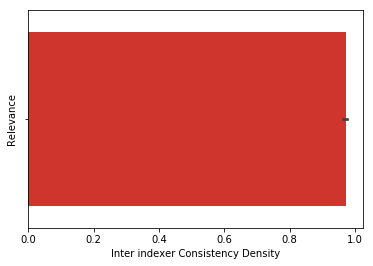

In [50]:
sns.barplot(x = similarity_relevance['Relevance'], color = '#E32219', saturation = .8)
plt.ylabel('Relevance')
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_relevance.png')

In [51]:
print ("The ICD between the analysts is:", round(np.mean(np.mean(similarity_relevance)),ndigits=3))

The ICD between the analysts is: 0.972


### 3.2) Quality metrics - Macro dimension of sentence

#### 3.2.1) Consistency metric

In [52]:
similarity_macro_dimension = np.empty([len(analysts),len(macro_features)])

for i in analysts:
    for k in macro_features['Features']:
        #all answers by one analyst and one category 
        #only keep the sentences for a category that at least one annotator has assigned that category to the sentence (centroid different of zero)
        temp_feat_ana = macro_dimension[k+' '+i][macro_dimension['Centroid '+k] != 0]
        temp_feat_cent = macro_dimension['Centroid '+k][macro_dimension['Centroid '+k] != 0]
        #if the category was considered by the analyst
        if (any(temp_feat_ana != 0)):
            #similarity of the answer of each analyst to the centroid (for each one of the sentences)
            similarity_macro_dimension[np.where(analysts==i)[0][0]][np.where(macro_features['Features']==k)[0][0]] = np.dot(temp_feat_ana, temp_feat_cent)/(norm(temp_feat_ana)*norm(temp_feat_cent))
        else:
            similarity_macro_dimension[np.where(analysts==i)[0][0]][np.where(macro_features['Features']==k)[0][0]] = 0

similarity_macro_dimension = pd.DataFrame(similarity_macro_dimension, columns = macro_features['Features'])
similarity_macro_dimension

Features,Flag - Dimension,Operational Environment - Dimension,Sectoral Information - Dimension,Sectoral Information - Sector
0,0.948519,0.956046,0.988882,0.988882
1,0.922053,0.944252,0.991048,0.991048
2,0.945645,0.956494,0.989108,0.989108
3,0.945724,0.939395,0.991048,0.991048


In [119]:
temp_mean = similarity_macro_dimension.stack().groupby('Features').mean()
temp_sd = similarity_macro_dimension.stack().groupby('Features').std()

temp_graph = pd.DataFrame(columns=['mean ICD','stdev'])
temp_graph['mean ICD']= temp_mean
temp_graph['stdev']= temp_sd
temp_graph = temp_graph.sort_values(by = ['mean ICD'], ascending = False)
temp_graph_head = temp_graph.head(5)
temp_graph_tail = temp_graph.tail(5)

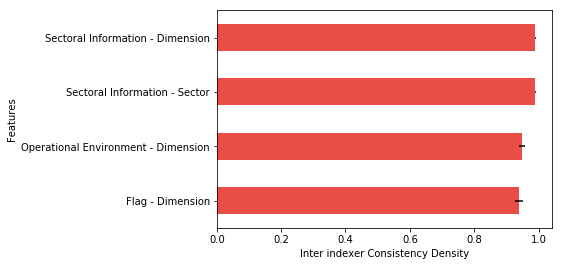

In [120]:
temp_graph_head.plot.barh(y = 'mean ICD',xerr = 'stdev',color='#E32219',alpha = .8, legend = None)
plt.gca().invert_yaxis()
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_macro_dimension_head.png', bbox_inches="tight")

#### 3.2.2) Tagging exhaustivity

In [55]:
nb_tags_macro_dimension = pd.DataFrame(macro_dimension['Sentence'])
for i in analysts:
    nb_tags_macro_dimension[i] = np.sum(macro_dimension.filter(regex=i) , axis=1)

nb_tags_macro_dimension['Average_tags'] = np.mean(nb_tags_macro_dimension.drop(columns = ['Sentence']),axis=1)
nb_tags_macro_dimension

,Sentence,Kriti Chhetri,Shweta Khatri,Sapana Dangol,Nagma Mathema,Average_tags
0,"Across the three affected states of Borno, Ada...",3,3,3,3,3.00
1,Over eighty per cent of internally displaced ...,3,3,3,3,3.00
2,One in four of the internally displaced people...,1,1,1,1,1.00
3,"However, some 1,6 million people have returne...",1,1,1,1,1.00
4,Humanitarian organisations are not able to me...,1,1,1,1,1.00
5,North-east Nigeria is one of the world’s large...,4,4,4,4,4.00
6,"Since the start of the conflict in 2009, more...",4,4,4,4,4.00
7,Attacks on camps for internally displaced peo...,4,4,4,4,4.00
8,Millions of people in north-east Nigeria rely ...,3,3,3,3,3.00
9,Despite significant improvements in 2017 and ...,3,3,3,3,3.00


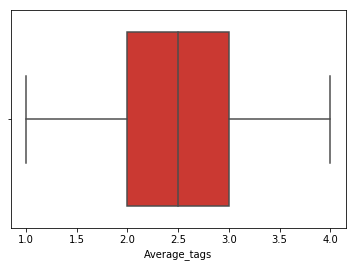

In [56]:
#Makes confidence interval with bootstrapping
##sns.barplot(nb_tags_macro_dimension['Average_tags']).get_figure().savefig('tagging_exhaustivity_macro_dimension.png')
sns.boxplot(nb_tags_macro_dimension['Average_tags'], color='#E32219').get_figure().savefig('tagging_exhaustivity_macro_dimension.png')

In [57]:
print ('The average of macro-dimensions tagged for a sentence is:', round(np.mean(nb_tags_macro_dimension['Average_tags']),ndigits=3))
print ('The total number of macro-dimensions is: ',len(macro_features))

The average of macro-dimensions tagged for a sentence is: 2.528
The total number of macro-dimensions is:  4


#### 3.2.3) Tag specificity

In [58]:
nb_docs_macro_dimension = pd.DataFrame(np.sum(macro_dimension.filter(regex = 'Centroid'),axis=0), columns = ['Average_doc']).sort_values(by = ['Average_doc'], ascending=False)
nb_docs_macro_dimension

,Average_doc
Centroid Sectoral Information - Dimension,392.25
Centroid Sectoral Information - Sector,392.25
Centroid Operational Environment - Dimension,240.50
Centroid Flag - Dimension,29.25


In [59]:
#analysis in proportional terms
nb_docs_macro_dimension = nb_docs_macro_dimension/len(macro_dimension)
nb_docs_macro_dimension  = nb_docs_macro_dimension.rename(columns={'Average_doc': 'Proportion_docs'})
nb_docs_macro_dimension.head(10)

,Proportion_docs
Centroid Sectoral Information - Dimension,0.940647
Centroid Sectoral Information - Sector,0.940647
Centroid Operational Environment - Dimension,0.576739
Centroid Flag - Dimension,0.070144


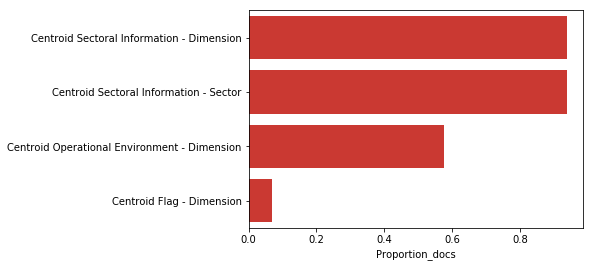

In [60]:
sns.barplot(x = nb_docs_macro_dimension['Proportion_docs'], y = nb_docs_macro_dimension.axes[0], color='#E32219').get_figure().savefig('tag_specificity_macro_dimension.png')


### 3.3) Quality metrics - Dimension of sentence

#### 3.3.1) Consistency metric

In [61]:
similarity_dimension = np.empty([len(analysts),len(dim_features)])

for i in analysts:
    for k in dim_features['Features']:
        #all answers by one analyst and one category 
        #only keep the sentences for a category that at least one annotator has assigned that category to the sentence (centroid different of zero)
        temp_feat_ana = dimension[k+' '+i][dimension['Centroid '+k] != 0]
        temp_feat_cent = dimension['Centroid '+k][dimension['Centroid '+k] != 0]
        if (any(temp_feat_ana != 0)):
            #similarity of the answer of each analyst to the centroid (for each one of the sentences)
            similarity_dimension[np.where(analysts==i)[0][0]][np.where(dim_features['Features']==k)[0][0]] = np.dot(temp_feat_ana, temp_feat_cent)/(norm(temp_feat_ana)*norm(temp_feat_cent))
        else:
            similarity_dimension[np.where(analysts==i)[0][0]][np.where(dim_features['Features']==k)[0][0]] = 0
similarity_dimension = pd.DataFrame(similarity_dimension, columns = dim_features['Features'])
similarity_dimension

Features,Operational Environment - Dimension Humanitarian Access,Operational Environment - Dimension Humanitarian Profile,Operational Environment - Dimension Context,Operational Environment - Dimension Information,Sectoral Information - Dimension Humanitarian Conditions,Sectoral Information - Dimension Scope & Scale,Sectoral Information - Dimension Capacities & Response,Sectoral Information - Sector Shelter,Sectoral Information - Sector Cross,Sectoral Information - Sector Protection,Sectoral Information - Sector Health,Sectoral Information - Sector Nutrition,Sectoral Information - Sector Food,Sectoral Information - Sector Livelihoods,Sectoral Information - Sector Education,Sectoral Information - Sector Agriculture,Sectoral Information - Sector Logistics,Sectoral Information - Sector WASH
0,0.924214,0.958127,0.925123,0.657376,0.985878,0.966955,0.948190,0.953643,0.929722,0.966423,0.969099,0.979573,0.948818,0.966636,0.947670,0.988111,0.995629,0.978752
1,0.924769,0.949158,0.840179,0.000000,0.984586,0.924114,0.812063,0.899675,0.898820,0.950810,0.956668,0.958399,0.919598,0.884309,0.938736,0.963612,0.995629,0.961428
2,0.957751,0.950467,0.917746,0.905789,0.988179,0.963152,0.905176,0.946916,0.909532,0.965496,0.947731,0.970846,0.957252,0.957861,0.975887,0.988111,0.995629,0.980821
3,0.941479,0.942954,0.853891,0.645497,0.986585,0.949263,0.908030,0.956498,0.920043,0.950781,0.932053,0.970846,0.935307,0.932648,0.943426,0.946244,0.952479,0.973196


In [121]:
temp_mean = similarity_dimension.stack().groupby('Features').mean()
temp_sd = similarity_dimension.stack().groupby('Features').std()

temp_graph = pd.DataFrame(columns=['mean ICD','stdev'])
temp_graph['mean ICD']= temp_mean
temp_graph['stdev']= temp_sd
temp_graph = temp_graph.sort_values(by = ['mean ICD'], ascending = False)
temp_graph_head = temp_graph.head(5)
temp_graph_tail = temp_graph.tail(5)

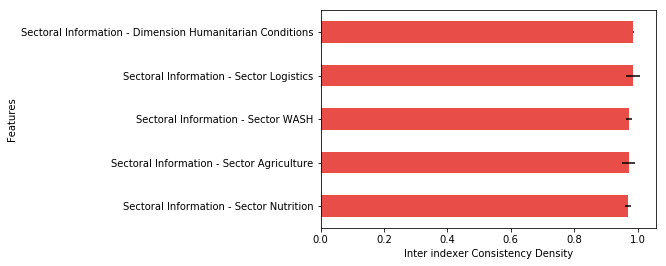

In [122]:
temp_graph_head.plot.barh(y = 'mean ICD',xerr = 'stdev',color='#E32219',alpha = .8, legend = None)
plt.gca().invert_yaxis()
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_dimension_head.png', bbox_inches="tight")

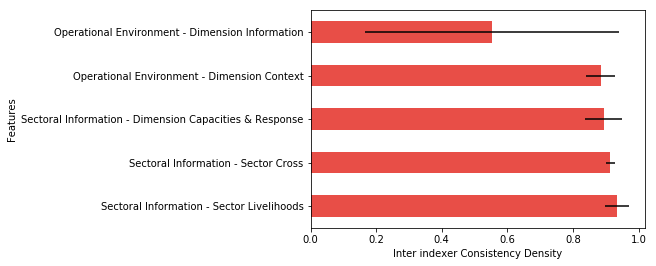

In [123]:
temp_graph_tail.plot.barh(y = 'mean ICD',xerr = 'stdev',color='#E32219',alpha = .8, legend = None)
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_dimension_tail.png', bbox_inches="tight")

In [65]:
print ("The ICD between the analysts is:", round(np.mean(np.mean(similarity_dimension)),ndigits=3))

The ICD between the analysts is: 0.925


In [66]:
(similarity_dimension[similarity_dimension<0.75].stack())

   Features                                       
0  Operational Environment - Dimension Information    0.657376
1  Operational Environment - Dimension Information    0.000000
3  Operational Environment - Dimension Information    0.645497
dtype: float64

#### 3.3.2) Tagging exhaustivity

In [67]:
nb_tags_dimension = pd.DataFrame(dimension['Sentence'])
for i in analysts:
    nb_tags_dimension[i] = np.sum(dimension.filter(regex=i) , axis=1)

nb_tags_dimension['Average_tags'] = np.mean(nb_tags_dimension.drop(columns = ['Sentence']),axis=1)
nb_tags_dimension.sample(5)

,Sentence,Kriti Chhetri,Shweta Khatri,Sapana Dangol,Nagma Mathema,Average_tags
95,"With such high levels of displacement in 2018,...",6,5,6,4,5.25
295,"In instances where health facilities exist, t...",3,3,4,3,3.25
308,Historically low levels of access to WASH ser...,4,4,4,4,4.00
323,The 2018 cholera outbreak across the BAY state...,4,4,4,4,4.00
401,The price of maize increased in August above ...,4,4,4,4,4.00


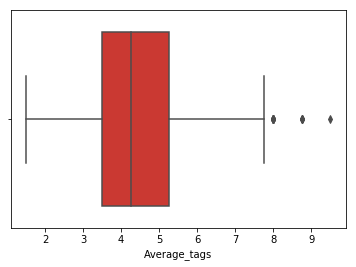

In [68]:
#Makes confidence interval with bootstrapping
#sns.barplot(nb_tags_dimension['Average_tags']).get_figure().savefig('tagging_exhaustivity_dimension.png')
sns.boxplot(nb_tags_dimension['Average_tags'], color='#E32219').get_figure().savefig('tagging_exhaustivity_dimension.png')

In [69]:
print ('The average of dimensions tagged for a sentence is:', round(np.mean(nb_tags_dimension['Average_tags']),ndigits=3))
print ('The total number of dimensions is: ',len(dim_features))

The average of dimensions tagged for a sentence is: 4.43
The total number of dimensions is:  18


#### 3.3.3) Tag specificity

In [70]:
nb_docs_dimension = pd.DataFrame(np.sum(dimension.filter(regex = 'Centroid'),axis=0), columns = ['Average_doc']).sort_values(by = ['Average_doc'], ascending=False)
nb_docs_dimension

,Average_doc
Centroid Sectoral Information - Dimension Humanitarian Conditions,378.25
Centroid Sectoral Information - Sector Protection,236.00
Centroid Sectoral Information - Dimension Scope & Scale,201.25
Centroid Sectoral Information - Sector Cross,169.25
Centroid Operational Environment - Dimension Humanitarian Profile,128.50
Centroid Operational Environment - Dimension Context,108.75
Centroid Sectoral Information - Sector Health,101.50
Centroid Sectoral Information - Sector Livelihoods,80.00
Centroid Operational Environment - Dimension Humanitarian Access,72.75
Centroid Sectoral Information - Sector Shelter,67.25


In [71]:
#analysis in proportional terms
nb_docs_dimension = nb_docs_dimension/len(dimension)
nb_docs_dimension  = nb_docs_dimension.rename(columns={'Average_doc': 'Proportion_docs'})
nb_docs_dimension
nb_docs_dimension_head = nb_docs_dimension.head()
nb_docs_dimension_tail = nb_docs_dimension.tail().sort_values(by = ['Proportion_docs'])

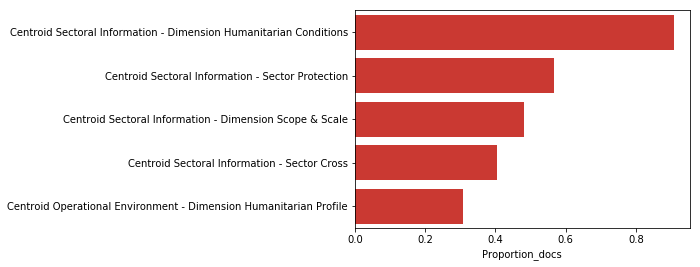

In [72]:
sns.barplot(x = nb_docs_dimension_head['Proportion_docs'], y = nb_docs_dimension_head.axes[0], color='#E32219').get_figure().savefig('tag_specificity_dimension_head.png')

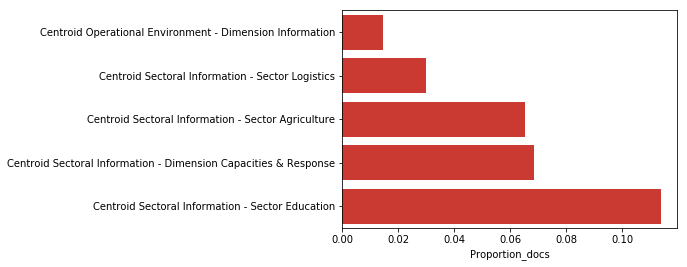

In [73]:
sns.barplot(x = nb_docs_dimension_tail['Proportion_docs'], y = nb_docs_dimension_tail.axes[0], color='#E32219').get_figure().savefig('tag_specificity_dimension_tail.png')

### 3.4) Quality metrics - Subdimension of sentence

#### 3.4.1) Consistency metric

In [74]:
similarity_subdimension = np.empty([len(analysts),len(subdim_features)])

for i in analysts:
    for k in subdim_features['Features']:
        #all answers by one analyst and one category 
        #only keep the sentences for a category that at least one annotator has assigned that category to the sentence (centroid different of zero)
        temp_feat_ana = subdimension[k+' '+i][subdimension['Centroid '+k] != 0]
        temp_feat_cent = subdimension['Centroid '+k][subdimension['Centroid '+k] != 0]
        #similarity of the answer of each analyst to the centroid (for each one of the sentences)
        if (any(temp_feat_ana != 0)):
            similarity_subdimension[np.where(analysts==i)[0][0]][np.where(subdim_features['Features']==k)[0][0]] = np.dot(temp_feat_ana, temp_feat_cent)/(norm(temp_feat_ana)*norm(temp_feat_cent))
        else:
            similarity_subdimension[np.where(analysts==i)[0][0]][np.where(subdim_features['Features']==k)[0][0]] = 0
similarity_subdimension = pd.DataFrame(similarity_subdimension, columns = subdim_features['Features'])
similarity_subdimension

Features,Flag - Subdimension Overview,Flag - Subdimension Stakeholders,Flag - Subdimension Key Event,Flag - Subdimension Hazard & Threats,Operational Environment - Subdimension Humanitarian Access Gaps,Operational Environment - Subdimension Affected Groups,Operational Environment - Subdimension Demography,Operational Environment - Subdimension Security,Operational Environment - Subdimension Casualties,Operational Environment - Subdimension Physical Constraints,...,Sectoral Information - Subdimension Risks & Vulnerabilities,Sectoral Information - Subdimension Damages & Losses,Sectoral Information - Subdimension Drivers/Aggravating Factors,Sectoral Information - Subdimension International Actors,Sectoral Information - Subdimension National Actors,Sectoral Information - Subdimension Government and Local Authorities,Sectoral Information - Subdimension System Disruption,Sectoral Information - Subdimension System Functionality,Sectoral Information - Subdimension People with Specific Needs,Sectoral Information - Subdimension Response Gaps
0,1.0,1.0,0.577350,0.912245,0.896106,0.968371,0.915447,0.927975,0.951163,0.952292,...,0.925791,0.973478,0.931750,0.930501,0.930949,0.750194,0.945173,0.967822,0.941033,0.0
1,1.0,1.0,0.816497,0.837134,0.935114,0.951655,0.830087,0.826161,0.931128,0.907123,...,0.917318,0.933916,0.914251,0.838742,0.837885,0.914991,0.855170,0.622171,0.821645,1.0
2,1.0,1.0,0.577350,0.914646,0.959619,0.956954,0.940596,0.899677,0.954360,0.933672,...,0.935262,0.958200,0.952708,0.838742,0.860828,0.862662,0.912912,0.967822,0.924083,0.0
3,1.0,1.0,0.816497,0.907268,0.911413,0.959806,0.929789,0.735417,0.944911,0.967118,...,0.931468,0.963623,0.923201,0.916579,0.903584,0.914991,0.909941,0.804334,0.923203,1.0


In [124]:
temp_mean = similarity_subdimension.stack().groupby('Features').mean()
temp_sd = similarity_subdimension.stack().groupby('Features').std()

temp_graph = pd.DataFrame(columns=['mean ICD','stdev'])
temp_graph['mean ICD']= temp_mean
temp_graph['stdev']= temp_sd
temp_graph = temp_graph.sort_values(by = ['mean ICD'], ascending = False)
temp_graph_head = temp_graph.head(5)
temp_graph_tail = temp_graph.tail(5)

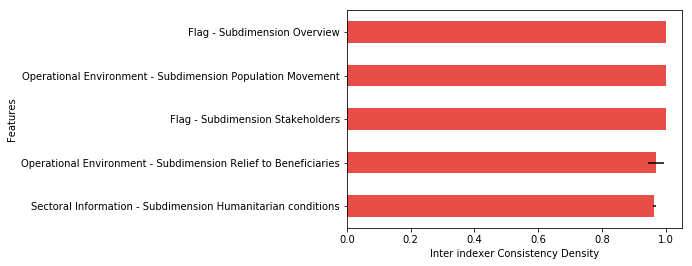

In [125]:
temp_graph_head.plot.barh(y = 'mean ICD',xerr = 'stdev',color='#E32219',alpha = .8, legend = None)
plt.gca().invert_yaxis()
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_subdimension_head.png', bbox_inches="tight")

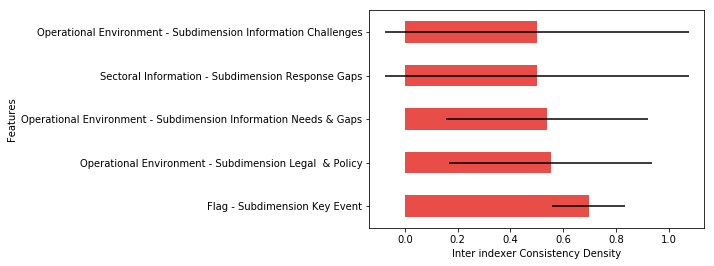

In [126]:
temp_graph_tail.plot.barh(y = 'mean ICD',xerr = 'stdev',color='#E32219',alpha = .8, legend = None)
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_subdimension_tail.png', bbox_inches="tight")

In [78]:
print ("The ICD between the analysts is:", round(np.mean(np.mean(similarity_dimension)),ndigits=3))

The ICD between the analysts is: 0.925


#### 3.4.2) Tagging exhaustivity

In [79]:
nb_tags_subdimension = pd.DataFrame(subdimension['Sentence'])
for i in analysts:
    nb_tags_subdimension[i] = np.sum(subdimension.filter(regex=i) , axis=1)

nb_tags_subdimension['Average_tags'] = np.mean(nb_tags_subdimension.drop(columns = ['Sentence']),axis=1)
nb_tags_subdimension.sample(5)

,Sentence,Kriti Chhetri,Shweta Khatri,Sapana Dangol,Nagma Mathema,Average_tags
444,"Moreover, the number of qualified teaching st...",2,3,2,2,2.25
266,"At least 770,000 children and caregivers in 39...",1,1,3,2,1.75
251,"Additionally, girls and boys affected are inc...",4,3,4,3,3.50
15,"More than 800,000 people are estimated to be ...",5,4,5,4,4.50
226,g,5,5,6,4,5.00


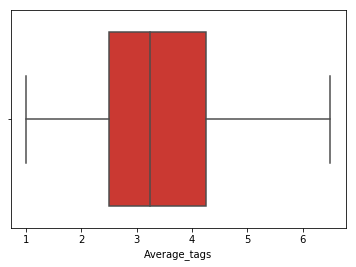

In [80]:
#Makes confidence interval with bootstrapping
#sns.barplot(nb_tags_subdimension['Average_tags']).get_figure().savefig('tagging_exhaustivity_subdimension.png')
sns.boxplot(nb_tags_subdimension['Average_tags'], color='#E32219').get_figure().savefig('tagging_exhaustivity_subdimension.png')

In [81]:
print ('The average of subdimensions tagged for a sentence is:', round(np.mean(nb_tags_subdimension['Average_tags']),ndigits=3))
print ('The total number of dimensions is: ',len(subdim_features))

The average of subdimensions tagged for a sentence is: 3.45
The total number of dimensions is:  33


#### 3.4.3) Tag specificity

In [82]:
nb_docs_subdimension = pd.DataFrame(np.sum(subdimension.filter(regex = 'Centroid'),axis=0), columns = ['Average_doc']).sort_values(by = ['Average_doc'], ascending=False)
nb_docs_subdimension

,Average_doc
Centroid Sectoral Information - Subdimension Risks & Vulnerabilities,223.25
Centroid Sectoral Information - Subdimension Living Standards,185.25
Centroid Sectoral Information - Subdimension Drivers/Aggravating Factors,156.00
Centroid Sectoral Information - Subdimension Physical & mental wellbeing,152.50
Centroid Operational Environment - Subdimension Affected Groups,95.75
Centroid Sectoral Information - Subdimension Humanitarian conditions,83.50
Centroid Sectoral Information - Subdimension Damages & Losses,70.75
Centroid Sectoral Information - Subdimension System Disruption,57.25
Centroid Operational Environment - Subdimension Demography,51.25
Centroid Sectoral Information - Subdimension Coping Mechanisms,43.50


In [83]:
#analysis in proportional terms
nb_docs_subdimension = nb_docs_subdimension/len(subdimension)
nb_docs_subdimension  = nb_docs_subdimension.rename(columns={'Average_doc': 'Proportion_docs'})
nb_docs_subdimension_head = nb_docs_subdimension.head()
nb_docs_subdimension_tail = nb_docs_subdimension.tail().sort_values(by = ['Proportion_docs'])

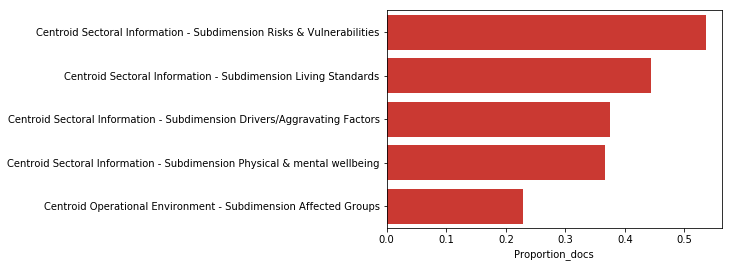

In [84]:
sns.barplot(x = nb_docs_subdimension_head['Proportion_docs'], y = nb_docs_subdimension_head.axes[0], color='#E32219').get_figure().savefig('tag_specificity_subdimension_head.png')

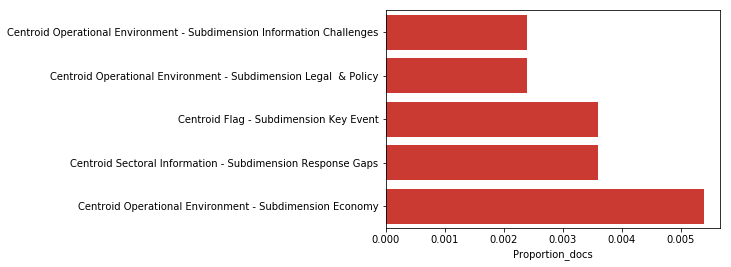

In [85]:
sns.barplot(x = nb_docs_subdimension_tail['Proportion_docs'], y = nb_docs_subdimension_tail.axes[0], color='#E32219').get_figure().savefig('tag_specificity_subdimension_tail.png')

### 3.5) Quality metrics - Full vocabulary on sentence

#### 3.5.1) Consistency metric

In [86]:
similarity_full_vocabulary = np.empty([len(analysts),len(categ_features)])

for i in analysts:
    for k in categ_features['Features']:
        #all answers by one analyst and one category 
        #only keep the sentences for a category that at least one annotator has assigned that category to the sentence (centroid different of zero)
        temp_feat_ana = full_vocabulary[k+' '+i][full_vocabulary['Centroid '+k] != 0]
        temp_feat_cent = full_vocabulary['Centroid '+k][full_vocabulary['Centroid '+k] != 0]
        #similarity of the answer of each analyst to the centroid (for each one of the sentences)
        if (any(temp_feat_ana != 0)):
            similarity_full_vocabulary[np.where(analysts==i)[0][0]][np.where(categ_features['Features']==k)[0][0]] = np.dot(temp_feat_ana, temp_feat_cent)/(norm(temp_feat_ana)*norm(temp_feat_cent))
        else:
            similarity_full_vocabulary[np.where(analysts==i)[0][0]][np.where(categ_features['Features']==k)[0][0]] = 0
similarity_full_vocabulary = pd.DataFrame(similarity_full_vocabulary, columns = categ_features['Features'])
similarity_full_vocabulary

Features,Operational Environment - Dimension Humanitarian Access,Operational Environment - Dimension Humanitarian Profile,Operational Environment - Dimension Context,Operational Environment - Dimension Information,Sectoral Information - Dimension Humanitarian Conditions,Sectoral Information - Dimension Scope & Scale,Sectoral Information - Dimension Capacities & Response,Sectoral Information - Sector Shelter,Sectoral Information - Sector Cross,Sectoral Information - Sector Protection,...,Local Authority (code) - Indicator Michika,Local Authority (code) - Indicator Askira/U,Local Authority (code) - Indicator Magumeri,Local Authority (code) - Indicator Mafa,Local Authority (code) - Indicator Biu,Local Authority (code) - Indicator Chikun,Local Authority (code) - Indicator Ogori/Magongo,Local Authority (code) - Indicator Chibok,Local Authority (code) - Indicator Southern Ijaw,Local Authority (code) - Indicator Damaturu
0,0.924214,0.958127,0.925123,0.657376,0.985878,0.966955,0.948190,0.953643,0.929722,0.966423,...,1.0,0.0,0.992157,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.924769,0.949158,0.840179,0.000000,0.984586,0.924114,0.812063,0.899675,0.898820,0.950810,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.957751,0.950467,0.917746,0.905789,0.988179,0.963152,0.905176,0.946916,0.909532,0.965496,...,1.0,0.0,0.992157,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,0.941479,0.942954,0.853891,0.645497,0.986585,0.949263,0.908030,0.956498,0.920043,0.950781,...,1.0,1.0,0.972272,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [127]:
temp_mean = similarity_full_vocabulary.stack().groupby('Features').mean()
temp_sd = similarity_full_vocabulary.stack().groupby('Features').std()

temp_graph = pd.DataFrame(columns=['mean ICD','stdev'])
temp_graph['mean ICD']= temp_mean
temp_graph['stdev']= temp_sd
temp_graph = temp_graph.sort_values(by = ['mean ICD'], ascending = False)
temp_graph_head = temp_graph.head(5)
temp_graph_tail = temp_graph.tail(5)

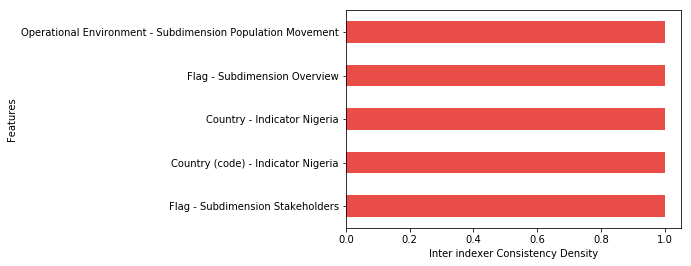

In [128]:
temp_graph_head.plot.barh(y = 'mean ICD',xerr = 'stdev',color='#E32219',alpha = .8, legend = None)
plt.gca().invert_yaxis()
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_full_vocabulary_head.png', bbox_inches="tight")

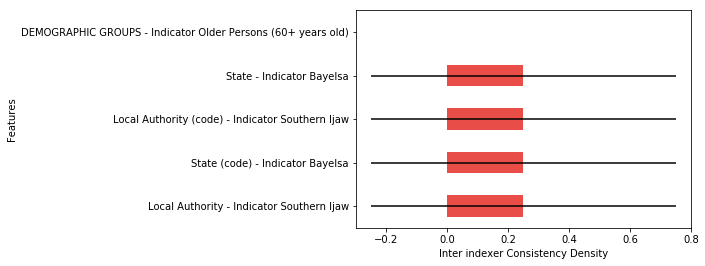

In [129]:
temp_graph_tail.plot.barh(y = 'mean ICD',xerr = 'stdev',color='#E32219',alpha = .8, legend = None)
plt.xlabel('Inter indexer Consistency Density').get_figure().savefig('consistency_metric_full_vocabulary_tail.png', bbox_inches="tight")

In [90]:
print ("The ICD between the analysts is:", round(np.mean(np.mean(similarity_full_vocabulary)),ndigits=3))

The ICD between the analysts is: 0.74


#### 3.5.2) Tagging exhaustivity

In [91]:
nb_tags_full_vocabulary = pd.DataFrame(full_vocabulary['Sentence'])
for i in analysts:
    nb_tags_full_vocabulary[i] = np.sum(full_vocabulary.filter(regex=i) , axis=1)

nb_tags_full_vocabulary['Average_tags'] = np.mean(nb_tags_full_vocabulary.drop(columns = ['Sentence']),axis=1)
nb_tags_full_vocabulary.sample(5)

,Sentence,Kriti Chhetri,Shweta Khatri,Sapana Dangol,Nagma Mathema,Average_tags
84,"These, and other existing bans on fish trade ...",24,20,24,25,23.25
13,The humanitarian community also faces restric...,13,10,13,11,11.75
18,"Today 1,8 million people are internally displa...",9,7,4,14,8.50
415,"In Yobe and Adamawa states, improved security ...",20,22,20,13,18.75
442,Learning spaces have also been reduced due to...,14,15,16,14,14.75


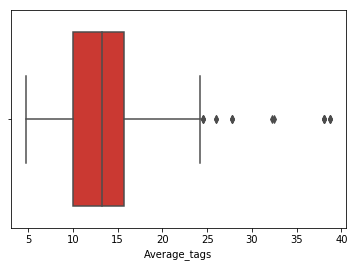

In [92]:
#Makes confidence interval with bootstrapping
#sns.barplot(nb_tags_full_vocabulary['Average_tags']).get_figure().savefig('tagging_exhaustivity_full_vocabulary.png')
sns.boxplot(nb_tags_full_vocabulary['Average_tags'],color='#E32219').get_figure().savefig('tagging_exhaustivity_full_vocabulary.png')

In [93]:
print ('The average of tags for a sentence is:', round(np.mean(nb_tags_full_vocabulary['Average_tags']),ndigits=3))
print ('The total number of possible tags is: ',len(categ_features))

The average of tags for a sentence is: 13.835
The total number of possible tags is:  146


#### 3.5.3) Tag specificity

In [130]:
nb_docs_full_vocabulary = pd.DataFrame(np.sum(full_vocabulary.filter(regex = 'Centroid'),axis=0), columns = ['Average_doc']).sort_values(by = ['Average_doc'], ascending=False)
nb_docs_full_vocabulary

,Average_doc
Centroid Country - Indicator Nigeria,417.00
Centroid Country (code) - Indicator Nigeria,417.00
Centroid Sectoral Information - Dimension Humanitarian Conditions,378.25
Centroid Sectoral Information - Sector Protection,236.00
Centroid State - Indicator Borno,230.00
Centroid State (code) - Indicator Borno,230.00
Centroid Sectoral Information - Subdimension Risks & Vulnerabilities,223.25
Centroid Sectoral Information - Dimension Scope & Scale,201.25
Centroid Sectoral Information - Subdimension Living Standards,185.25
Centroid Sectoral Information - Sector Cross,169.25


In [131]:
#analysis in proportional terms
nb_docs_full_vocabulary = nb_docs_full_vocabulary/len(full_vocabulary)
nb_docs_full_vocabulary = nb_docs_full_vocabulary.rename(columns={'Average_doc': 'Proportion_docs'})
nb_docs_full_vocabulary_head = nb_docs_full_vocabulary.head()
nb_docs_full_vocabulary_tail = nb_docs_full_vocabulary.tail()
nb_docs_full_vocabulary_tail = nb_docs_full_vocabulary_tail.sort_values(by = ['Proportion_docs'])

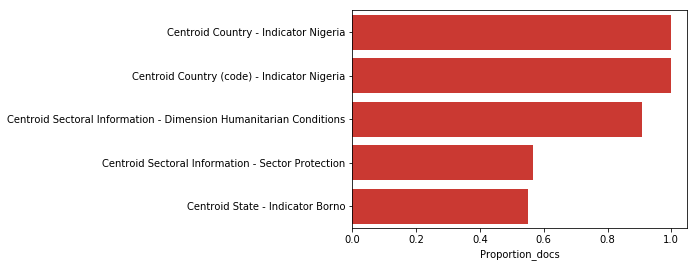

In [132]:
sns.barplot(x = nb_docs_full_vocabulary_head['Proportion_docs'], y = nb_docs_full_vocabulary_head.axes[0], color='#E32219').get_figure().savefig('tag_specificity_full_vocabulary_head.png')

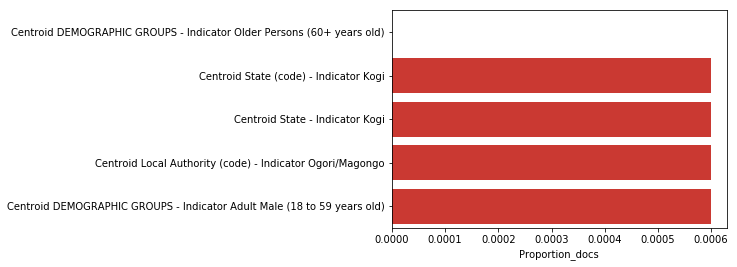

In [133]:
sns.barplot(x = nb_docs_full_vocabulary_tail['Proportion_docs'], y = nb_docs_full_vocabulary_tail.axes[0], color='#E32219').get_figure().savefig('tag_specificity_full_vocabulary_tail.png')